Configuración y Carga de Datos

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# --- CONFIGURACIÓN ---
DATA_DIR = os.path.join('..', 'data', 'raw')
IMG_SIZE = (224, 224) # VGG16 usa 224x224
BATCH_SIZE = 32

# Lista EXACTA basada en tu carpeta (Ordenada Alfabéticamente)
# TensorFlow asigna índices (0, 1, 2...) en orden alfabético.
SELECTED_CLASSES = [
    "Denzel Washington",
    "Hugh Jackman",
    "Jennifer Lawrence",
    "Megan Fox",
    "Natalie Portman",
    "Scarlett Johansson"
]

print(f"Buscando datos en: {os.path.abspath(DATA_DIR)}")
print(f"Clases seleccionadas ({len(SELECTED_CLASSES)}): {SELECTED_CLASSES}")

# --- CARGA DE DATOS ---
try:
    # Entrenamiento (80%)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='int', # 'int' es necesario para Sparse Categorical Crossentropy
        class_names=SELECTED_CLASSES # Filtra solo estas carpetas
    )

    # Validación (20%)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='int',
        class_names=SELECTED_CLASSES
    )

    print(f"Clases cargadas correctamente: {train_ds.class_names}")

    # Optimización de memoria (Cache y Prefetch)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

except Exception as e:
    print(f"ERROR: {e}")
    print("Verifica que las carpetas existan y tengan el nombre exacto.")

Buscando datos en: c:\Users\josue\UNI\celebrity-face-classifier\data\raw
Clases seleccionadas (6): ['Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Megan Fox', 'Natalie Portman', 'Scarlett Johansson']
Found 700 files belonging to 6 classes.
Using 560 files for training.
Found 700 files belonging to 6 classes.
Using 140 files for validation.
Clases cargadas correctamente: ['Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Megan Fox', 'Natalie Portman', 'Scarlett Johansson']


Arquitectura VGG16 (Desde Cero)

In [6]:
def build_vgg_optimized(num_classes):
    model = models.Sequential()
    
    model.add(layers.Input(shape=(224, 224, 3)))
    model.add(layers.Rescaling(1./255))
    
    # Data Augmentation un poco más agresivo
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.2))
    model.add(layers.RandomZoom(0.2))

    # --- BLOQUE 1 (32 filtros en vez de 64) ---
    # BatchNormalization va SIEMPRE entre la Convolución y la Activación
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization()) 
    model.add(layers.Activation('relu'))
    
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.MaxPooling2D((2, 2)))

    # --- BLOQUE 2 (64 filtros) ---
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.MaxPooling2D((2, 2)))

    # --- BLOQUE 3 (128 filtros) ---
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.MaxPooling2D((2, 2)))

    # --- BLOQUE 4 (256 filtros) ---
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.MaxPooling2D((2, 2)))

    # --- CLASIFICADOR ---
    model.add(layers.Flatten())
    
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization()) # Batch Norm también aquí
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Construir
num_classes = len(SELECTED_CLASSES)
model = build_vgg_optimized(num_classes)

# Usamos un Learning Rate más bajo (0.0001) para que aprenda despacio pero seguro
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,58

 Total params: 14,023,974 (53.50 MB)

 Trainable params: 14,021,542 (53.49 MB)

 Non-trainable params: 2,432 (9.50 KB)

Entrenamiento

Iniciando entrenamiento con arquitectura optimizada y pesos...
Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.2625 - loss: 3.8085 - val_accuracy: 0.1643 - val_loss: 1.8422
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.3518 - loss: 3.1454 - val_accuracy: 0.1786 - val_loss: 1.9537
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4661 - loss: 2.5738 - val_accuracy: 0.1786 - val_loss: 2.1846
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4982 - loss: 2.3531 - val_accuracy: 0.1786 - val_loss: 2.5136
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.5375 - loss: 2.1768 - val_accuracy: 0.1786 - val_loss: 2.8136
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.5750 - loss: 1.9566 - val_accuracy: 0.1786 - val_loss: 3.0076
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.6393 - loss: 1.6109 - val_accuracy: 0.1786 - val_loss: 3.0719
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - acc

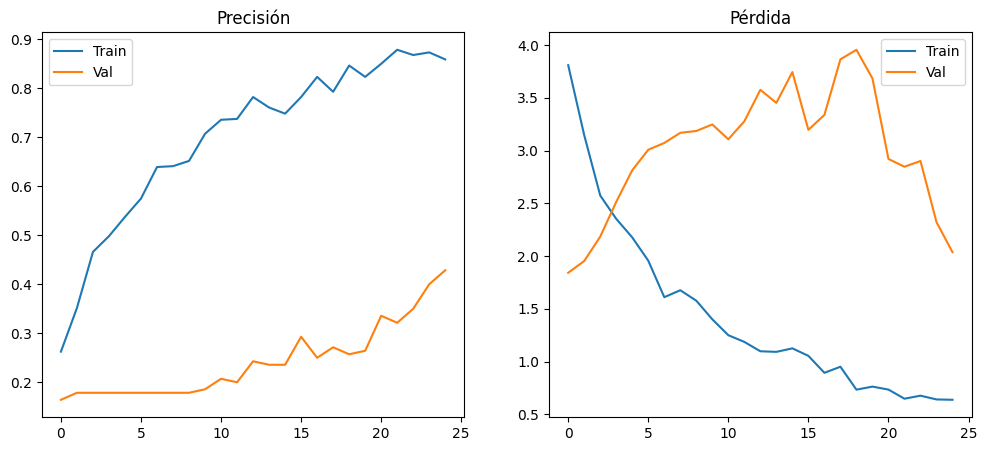

In [7]:
from sklearn.utils import class_weight 
# NOTA: Si no te dejan usar sklearn NI SIQUIERA para calcular pesos, 
# avísame y te paso la fórmula manual. Pero para pesos suele permitirse.
# Si no, usa weights = {0: 2.0, 1: 2.0, ... 5: 1.0} ajustando a ojo.

# Opción manual rápida (Asumiendo que Scarlett es la clase 5 y tiene el doble de fotos)
# Denzel(0), Hugh(1), Jennifer(2), Megan(3), Natalie(4), Scarlett(5)
manual_weights = {
    0: 2.0, # Denzel
    1: 2.0, # Hugh
    2: 2.0, # Jennifer
    3: 2.0, # Megan
    4: 2.0, # Natalie
    5: 1.0  # Scarlett (Clase mayoritaria, pesa menos)
}

print("Iniciando entrenamiento con arquitectura optimizada y pesos...")

epochs = 25 # Subimos un poco las épocas
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=manual_weights # <--- ESTO ES CLAVE
)

# --- Gráficas ---
# (El código de gráficas es igual al anterior)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Pérdida')
plt.legend()
plt.show()

Evaluación y Matriz de Confusión

Generando Matriz de Confusión Multiclase...


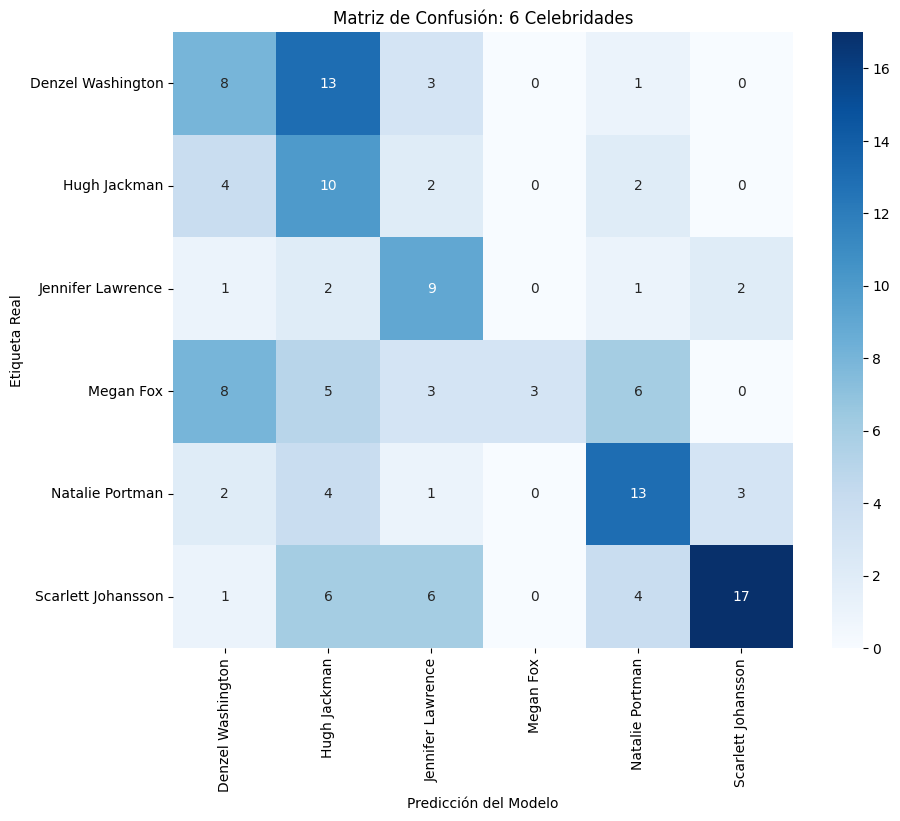

In [8]:
print("Generando Matriz de Confusión Multiclase...")

y_true = []
y_pred = []

# Iterar sobre el set de validación imagen por imagen
for image, label in val_ds.unbatch():
    y_true.append(label.numpy())
    
    # Predecir
    img_batch = tf.expand_dims(image, 0)
    prediction = model.predict(img_batch, verbose=0)
    
    # Obtener el índice con mayor probabilidad (Argmax)
    predicted_index = np.argmax(prediction)
    y_pred.append(predicted_index)

# Crear Matriz con TensorFlow
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# Graficar
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues',
            xticklabels=SELECTED_CLASSES,
            yticklabels=SELECTED_CLASSES)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión: 6 Celebridades')
plt.show()

Guardar Modelo

In [9]:
# Crear carpeta models si no existe
if not os.path.exists('../models'):
    os.makedirs('../models')

save_path = '../models/celebrity_vgg16.keras'
model.save(save_path)
print(f"✅ Modelo guardado exitosamente en: {save_path}")

✅ Modelo guardado exitosamente en: ../models/celebrity_vgg16.keras
